# Module 6 - Regression Analysis Using the Medical Cost Dataset
**Author:** Kellie Leopold  
**Date:** November 25, 2025  
**Objective:** Predict medical insurance charges using personal and lifestyle factors.


## Introduction

This project explores what affects medical insurance costs and how different models can predict those costs. Using the Medical Cost dataset, I look at how age, BMI, smoking status, number of children, sex, and region relate to insurance charges. I clean the data, handle missing values, and create new features to help the models understand the patterns. Then I train and compare several regression models, including basic linear regression and models built with pipelines. The goal is to follow the full process from exploring the data to evaluating the models while learning which features matter most and how to improve prediction accuracy.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

## Section 1. Load and Explore the Data

### 1.1 Load the Dataset and Display the First 10 Rows

In [2]:
# Load the dataset
df = pd.read_csv("data/insurance.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Display Summary Statistics and Missing Values

In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**Reflection 1**  

The dataset contains seven features and over a thousand entries, and there are no missing values, so it is already in good shape. The numeric columns like age, BMI, and children are ready for modeling, while the categorical columns like sex, smoker, and region need to be encoded. Overall, the dataset is clean and easy to work with, which helps make the next steps straightforward.

## Section 2. Data Exploration and Preparation

### 2.1 Visual Exploration

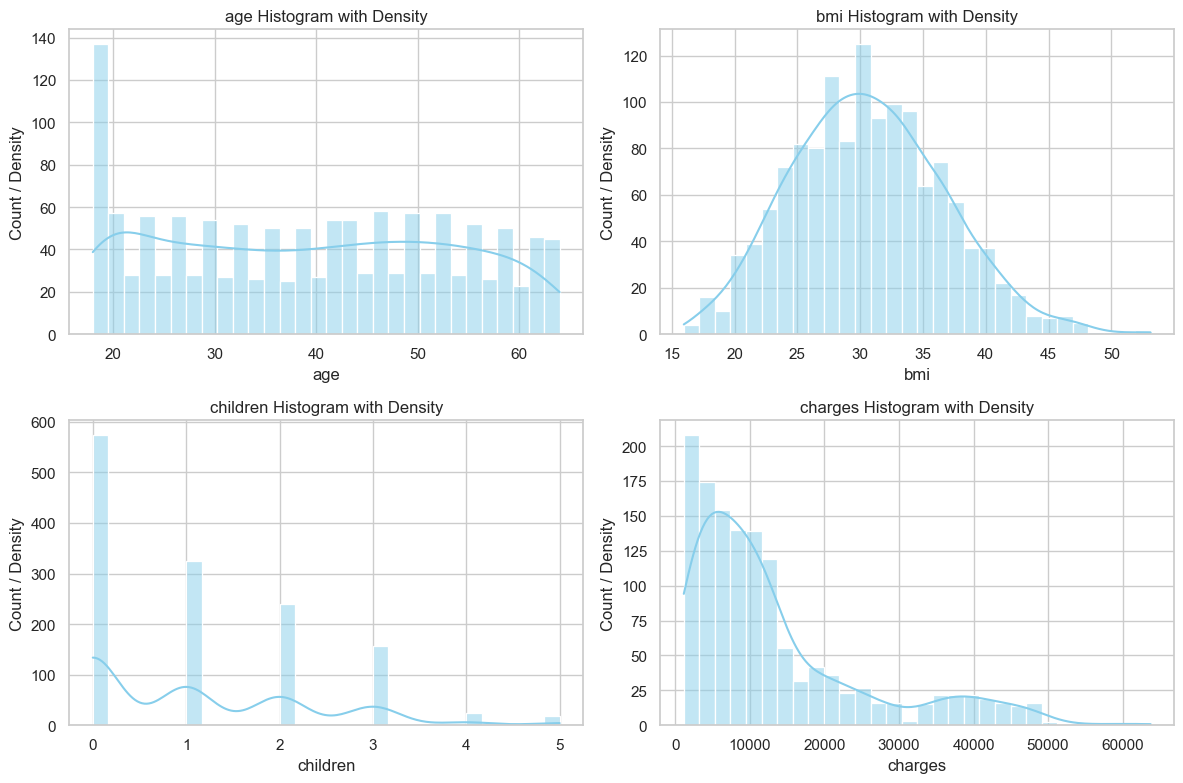

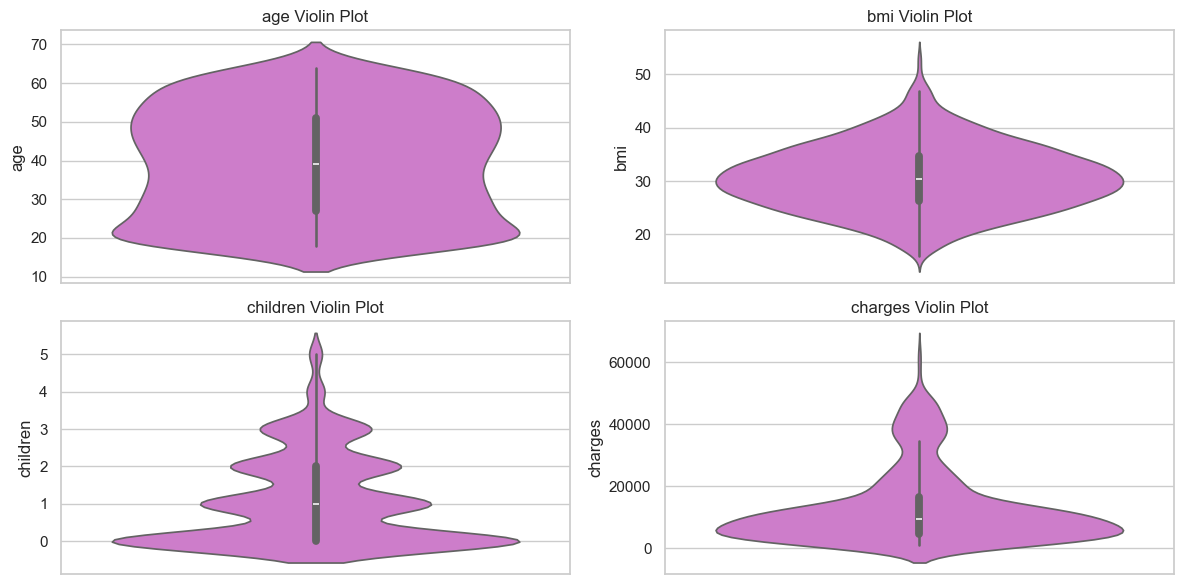

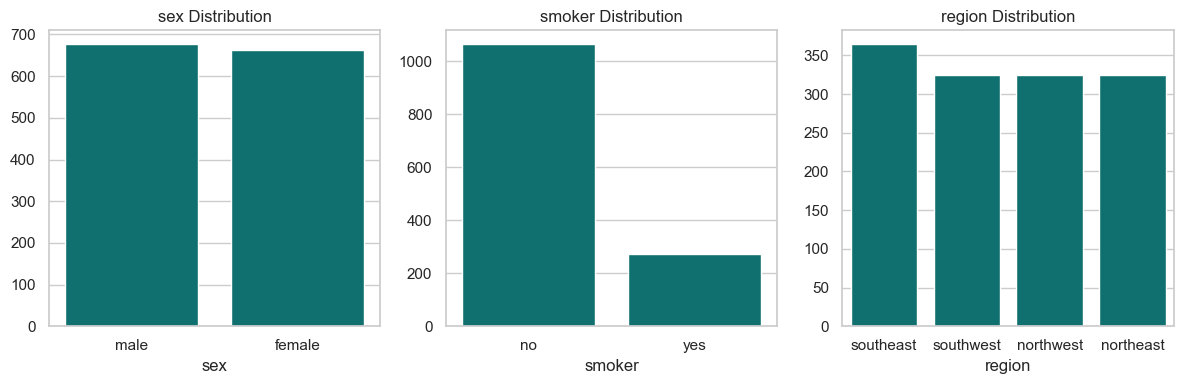

In [4]:

sns.set(style="whitegrid", palette="muted")

numeric_cols = ["age", "bmi", "children", "charges"]

# Histograms with density overlay
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[col], bins=30, kde=True, color="skyblue")
    plt.title(f"{col} Histogram with Density")
    plt.xlabel(col)
    plt.ylabel("Count / Density")
plt.tight_layout()
plt.show()

# Violin plots for numeric spread/outliers
plt.figure(figsize=(12,6))
for i, col in enumerate(numeric_cols,1):
    plt.subplot(2,2,i)
    sns.violinplot(y=df[col], color="orchid")
    plt.title(f"{col} Violin Plot")
plt.tight_layout()
plt.show()

# Categorical features
categorical_cols = ["sex", "smoker", "region"]

plt.figure(figsize=(12,4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1,3,i)
    counts = df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, color="teal")  # use single color
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

### 2.2 Handle Missing Values

In [5]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

### 2.3 Feature Selection and Engineering

In [6]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
df_encoded['smoker_yes'] = df_encoded['smoker_yes'].astype(int)

# Log-transform charges to reduce skew
df_encoded['charges_log'] = np.log1p(df_encoded['charges'])

# BMI vs Charges (log scale)
df_encoded['bmi_charges'] = df_encoded['bmi'] * df_encoded['charges_log']

# Smoking vs Charges
df_encoded['smoker_charges'] = df_encoded['smoker_yes'] * df_encoded['charges_log']

# BMI vs Smoking
df_encoded['bmi_smoker'] = df_encoded['bmi'] * df_encoded['smoker_yes']

# Check first 5 rows
print(df_encoded[['age', 'bmi', 'children', 'charges', 'charges_log',
'bmi_charges', 'smoker_yes', 'smoker_charges', 'bmi_smoker']].head())

   age     bmi  children      charges  charges_log  bmi_charges  smoker_yes  \
0   19  27.900         0  16884.92400     9.734236   271.585175           1   
1   18  33.770         1   1725.55230     7.453882   251.717589           0   
2   28  33.000         3   4449.46200     8.400763   277.225185           0   
3   33  22.705         0  21984.47061     9.998137   227.007703           0   
4   32  28.880         0   3866.85520     8.260455   238.561953           0   

   smoker_charges  bmi_smoker  
0        9.734236        27.9  
1        0.000000         0.0  
2        0.000000         0.0  
3        0.000000         0.0  
4        0.000000         0.0  


**Reflection 2:**

When looking at the data, I noticed that charges were heavily skewed, and BMI had some wide variation and possible outliers. Smoking also stood out as an important factor because the smoker and non smoker groups looked very different. To prepare the data, I filled in missing BMI values, encoded the categorical features, and created a few interaction features to help the model pick up patterns that the basic variables might miss.

## Section 3. Feature Selection and Justification

### 3.1 Choose Features and Target

**Input Features:**

* age: Numeric, known to influence insurance charges.
* bmi: Numeric, directly linked to health risk and costs.
* children: Numeric, number of dependents may impact charges.
* smoker_yes: Categorical (converted to numeric 0/1), smoking significantly affects health costs.
* bmi_charges: Interaction feature capturing combined effect of BMI and charges.
* smoker_charges: Interaction feature capturing smoking impact on charges.
* bmi_smoker: Interaction feature capturing BMI specifically for smokers.

**Target Variable:**

* charges: Continuous numeric variable representing medical insurance costs.

**Justification:**
These features were selected because they are known predictors of insurance charges. Interaction features were added to explicitly capture relationships between BMI, smoking, and costs, which can help the model better understand complex patterns in the data.  

### 3.2 Define X and y

In [7]:
# Target variable
y = df_encoded['charges']

# Features
X = df_encoded[['age', 'bmi', 'children', 'smoker_yes', 'bmi_charges', 'smoker_charges', 'bmi_smoker']]

**Reflection 3:**

I chose these features because they play a clear role in predicting medical costs. Age, BMI, and number of children are straightforward factors tied to health and expenses. Smoking status is especially important because it has a big impact on charges. I also created interaction features to show how some of these variables work together, such as how BMI and smoking might combine to raise costs. These added features help the model understand more complex patterns and make better predictions.

## Section 4. Train a Regression Model

### 4.1 Split the Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.2 Train and Evaluate Linear Regression Models

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 4.3 Report Performance

In [10]:
y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Performance:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR^2: {r2:.3f}")

Linear Regression Performance:
MAE: 1678.92
RMSE: 2346.50
R^2: 0.965


**Reflection 4:**

The Linear Regression model performed really well overall. It explained most of the variation in insurance charges, and the errors showed that its predictions were usually close to the real values. Some larger mistakes happened, likely because of outliers or unusual cases. Using both the original features and the interaction features helped the model learn more of the patterns in the data, which is probably why it performed so strongly.

## Section 5. Improve the Model (Implement Pipelines)

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.

In [11]:
pipeline1 = Pipeline([
('imputer', SimpleImputer(strategy='median')), # in case any numeric missing values exist
('scaler', StandardScaler()),
('lin_reg', LinearRegression())
])

pipeline1.fit(X_train, y_train)
y_pred1 = pipeline1.predict(X_test)

mae1 = mean_absolute_error(y_test, y_pred1)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
r21 = r2_score(y_test, y_pred1)

print("Pipeline 1 Performance:")
print(f"MAE: {mae1:.2f}, RMSE: {rmse1:.2f}, R^2: {r21:.3f}\n")

Pipeline 1 Performance:
MAE: 1678.92, RMSE: 2346.50, R^2: 0.965



### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.

In [12]:
pipeline2 = Pipeline([
('imputer', SimpleImputer(strategy='median')),
('poly', PolynomialFeatures(degree=3, include_bias=False)),
('scaler', StandardScaler()),
('lin_reg', LinearRegression())
])

pipeline2.fit(X_train, y_train)
y_pred2 = pipeline2.predict(X_test)

mae2 = mean_absolute_error(y_test, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
r22 = r2_score(y_test, y_pred2)

print("Pipeline 2 Performance:")
print(f"MAE: {mae2:.2f}, RMSE: {rmse2:.2f}, R^2: {r22:.3f}\n")

Pipeline 2 Performance:
MAE: 182.77, RMSE: 323.57, R^2: 0.999



### 5.3 Compare performance of all models across the same performance metrics

In [13]:
performance_comparison = pd.DataFrame({
'Pipeline': ['Pipeline 1', 'Pipeline 2'],
'MAE': [mae1, mae2],
'RMSE': [rmse1, rmse2],
'R^2': [r21, r22]
})

print(performance_comparison)

     Pipeline          MAE         RMSE       R^2
0  Pipeline 1  1678.918400  2346.495385  0.964534
1  Pipeline 2   182.772576   323.571754  0.999326


**Reflection 5**  

Pipeline 2 performed much better than Pipeline 1. The polynomial features helped the model learn more complex relationships in the data, which lowered the errors and boosted the R^2 score almost to 1. Pipeline 1 was simpler and easier to interpret but missed some of those deeper patterns. Scaling helped both models by keeping everything on a similar range. Overall, the extra flexibility in Pipeline 2 made it much more accurate.

## Section 6. Final Thoughts & Insights

### 6.1 Summarize Findings

* This project explored how factors like age, BMI, number of children, and smoking status influence medical insurance charges.
* Linear Regression captured most of the variance (R^2 ≈ 0.965), and adding interaction terms helped model combined effects.
* Using polynomial features in a pipeline improved predictions even further, achieving very low errors and R^2 near 1. 
* Overall, age, BMI, and smoking are the strongest predictors of insurance costs, and interactions matter.

### 6.2 Discuss Challenges

* Handling skewed distributions of charges (addressed with log transformation).
* Deciding which interaction features to include without overcomplicating the model.
* Ensuring all features were correctly scaled and encoded for regression.

### 6.3 If given more time, what would I try next?

* Explore additional non-linear models like Random Forest or Gradient Boosting to see if they outperform polynomial regression.
* Investigate potential outliers or unusual cases in the data.
* Experiment with feature selection techniques to simplify the model without losing accuracy.

**Reflection 6:**

From this project, I learned how much feature engineering and interaction terms can improve a model. I also gained experience using pipelines, scaling, and evaluating models with different metrics. Most importantly, I learned how to interpret what the models are telling me and how the features relate to real insurance costs. It showed me how modeling is not just about building a prediction but also about understanding the story the data tells.